In [338]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns

## Data

In [365]:
data = pd.read_csv("distances_Tpeak_temporal_ind_24102023_wide.csv")
data = data[(data["FlashType"] == 1) | (data["FlashType"] == 2)]


<Axes: xlabel='correct_rel', ylabel='Count'>

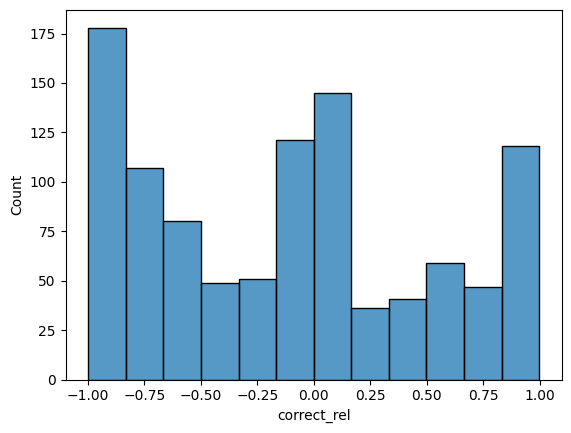

In [366]:
sns.histplot(data["correct_rel"])

In [367]:
correct_rel = data["correct_rel"]
rt_Cod = data["rt_Cod"]

In [369]:
data = data.drop(["participant_id","correct", "rt","correct_abs", "rt_abs", "correct_rel", "rt_Cod","rt_rel", "bl_correct","bl_rt", "CFF", "Dist to A1, LH", "Dist to A1, RH", "Dist to V1, LH", "Dist to V1, RH", "dist_ratio_L", "dist_ratio_R"], axis=1, index=None)


In [370]:
data

,FlashType,NrBeeps,sex,age
0,1,1,1,20.7
1,1,2,1,20.7
2,2,1,1,20.7
3,2,2,1,20.7
8,1,1,0,20.9
...,...,...,...,...
2051,2,2,0,21.0
2056,1,1,0,25.3
2057,1,2,0,25.3
2058,2,1,0,25.3


## Pipeline

In [371]:
num_features = data.columns[3:].to_list()
# ord_features = [data_flash1.columns[0]]
cat_features = data.columns[:3].to_list()

In [372]:
whiten = Pipeline(
    steps = [("whiten", StandardScaler())]
)

cat_encoder = Pipeline(
    steps = [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

ord_encoder = Pipeline(
    steps = [("cat_encoder", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("whiten", whiten, num_features),
        # ("ord_encoder", ord_encoder, cat_features),
        ("cat_encoder", cat_encoder, cat_features)
    ]
)

# 1. Modeling Relative Correct Rate

In [373]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
model_pipe = Pipeline([('preprocessor', preprocessor),
                ('linreg',linreg)])

In [374]:
X_train, X_test, y_train, y_test = train_test_split(data, correct_rel, test_size=0.25, random_state=42)

In [375]:
cat_feature_names = ["FlashType_1", "FlashType_2", "NrBeeps_1", "NrBeeps_2", "Sex_0", "Sex_1"]
feature_names = cat_feature_names + list(num_features)

In [376]:
len(feature_names)

7

In [377]:
# 5-fold CV
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = cross_validate(model_pipe, X_train, y_train, cv=cv, scoring=['r2', 'neg_mean_squared_error'], return_estimator =True, n_jobs = -1)

In [378]:
print("Mean R2 across folds: ", np.mean(cv_results['test_r2']))

Mean R2 across folds:  0.6596272032434676


In [379]:
coefs = pd.DataFrame(
    [
        est[-1].coef_[0] * est[:-1].transform(X_train.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_results["estimator"], cv.split(X_train, y_train))
    ],
    columns = feature_names
)

Text(0.5, 1.0, 'Coefficient importance and its variability')

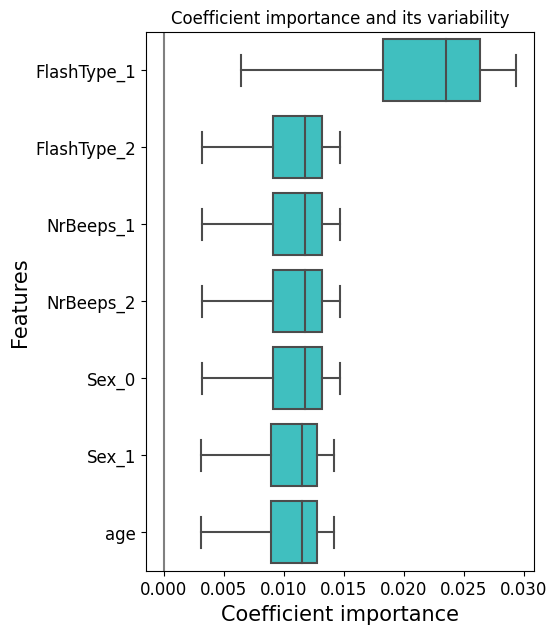

In [380]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=coefs.iloc[:, :100], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
ax.set_ylabel("Features", fontsize = 15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")

## Permutation Feature Importance

In [381]:
trained_linreg = linreg.fit(X_train, y_train)

/home/victoria/.conda/envs/neuro/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


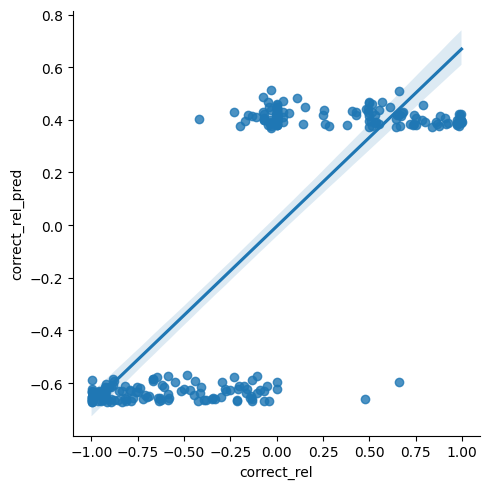

In [382]:
y_pred = trained_linreg.predict(X_test)
test_pred_df = pd.DataFrame({"correct_rel": y_test, "correct_rel_pred": y_pred})
sns.lmplot(test_pred_df, x = "correct_rel", y = "correct_rel_pred")

<Axes: ylabel='Count'>

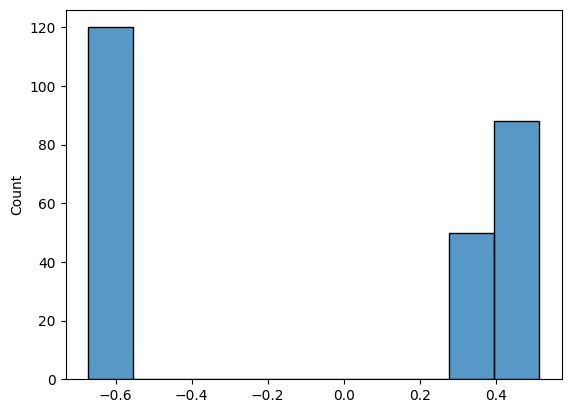

In [383]:
sns.histplot(y_pred)

# Modeling RT Cohen's d

In [275]:
X_train, X_test, y_train, y_test = train_test_split(data, rt_Cod, test_size=0.25, random_state=42)

In [312]:
trained_linreg.score(X_test, y_test)

0.6463626902335287

<Axes: xlabel='correct_rel', ylabel='Count'>

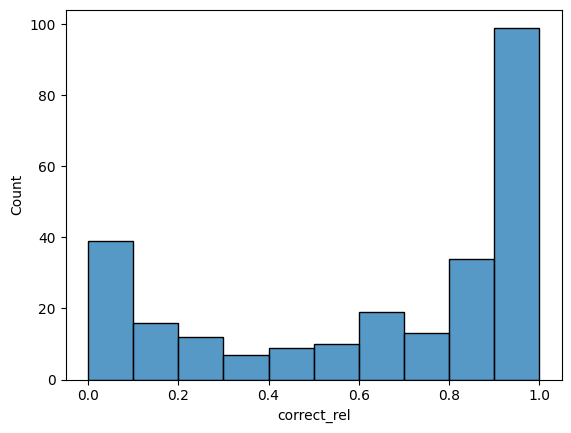

In [316]:
sns.histplot(test_pred_df["correct_rel"])


/home/victoria/.conda/envs/neuro/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


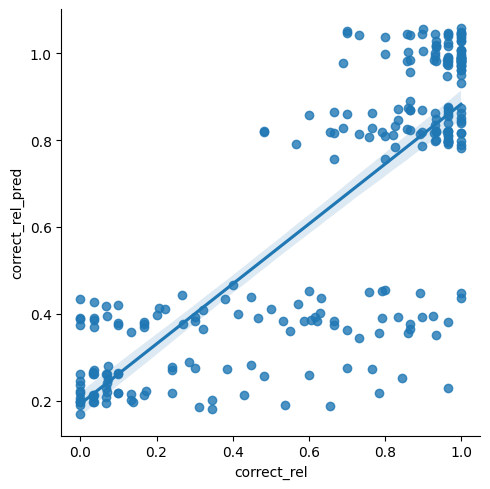

In [315]:
# make an lmplot of y_test and y_pred

y_pred = trained_linreg.predict(X_test)
test_pred_df = pd.DataFrame({"correct_rel": y_test, "correct_rel_pred": y_pred})
sns.lmplot(test_pred_df, x = "correct_rel", y = "correct_rel_pred")

In [314]:
y_pred

array([0.41349886, 1.04416106, 0.87275917, 0.24175074, 0.97921699,
       0.98460468, 1.05689539, 0.38233884, 0.9756702 , 1.03881293,
       0.99731776, 0.87482508, 0.79074588, 0.98252251, 0.19129034,
       0.2672274 , 0.78923675, 1.04737082, 0.27855326, 0.99316963,
       0.38557331, 0.21825129, 0.98207261, 1.0171364 , 0.97165807,
       1.00424829, 1.03580564, 0.79609357, 0.1809285 , 0.97885778,
       0.97722899, 0.27962588, 0.26030873, 0.37692207, 0.39256515,
       0.86293658, 0.25692136, 0.38020264, 0.19465696, 0.82661828,
       0.78066227, 0.27509132, 0.26219566, 0.85867465, 0.35528017,
       0.26204556, 0.98105842, 0.19739151, 0.828218  , 0.80024074,
       0.87049289, 0.38484106, 0.81583613, 0.7973064 , 0.98659406,
       0.98790584, 1.0370084 , 0.45216658, 0.81984428, 0.81761193,
       0.3926754 , 0.41740264, 0.42323228, 0.82633342, 0.79652017,
       0.81752161, 0.21923865, 0.9574428 , 0.86866314, 1.04077957,
       0.38354792, 0.21827758, 0.37674962, 0.4028359 , 0.17006

In [276]:
# 5-fold CV
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = cross_validate(model_pipe, X_train, y_train, cv=cv, scoring=['r2', 'neg_mean_squared_error', 'explained_variance'], return_estimator =True, n_jobs = -1)

In [277]:
cv_results

{'fit_time': array([0.00938392, 0.0062685 , 0.00590825, 0.00945354, 0.01070333]),
 'score_time': array([0.00554156, 0.00334287, 0.0034039 , 0.0052681 , 0.0055747 ]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('whiten',
                                                    Pipeline(steps=[('whiten',
                                                                     StandardScaler())]),
                                                    ['age', 'Dist to A1, LH',
                                                     'Dist to A1, RH',
                                                     'Dist to V1, LH',
                                                     'Dist to V1, RH',
                                                     'dist_ratio_L',
                                                     'dist_ratio_R']),
                                                   ('cat_encoder',
                                                    Pipel

In [278]:
coefs = pd.DataFrame(
    [
        est[-1].coef_[0] * est[:-1].transform(X_train.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_results["estimator"], cv.split(X_train, y_train))
    ],
    columns = feature_names
)

Text(0.5, 1.0, 'Coefficient importance and its variability')

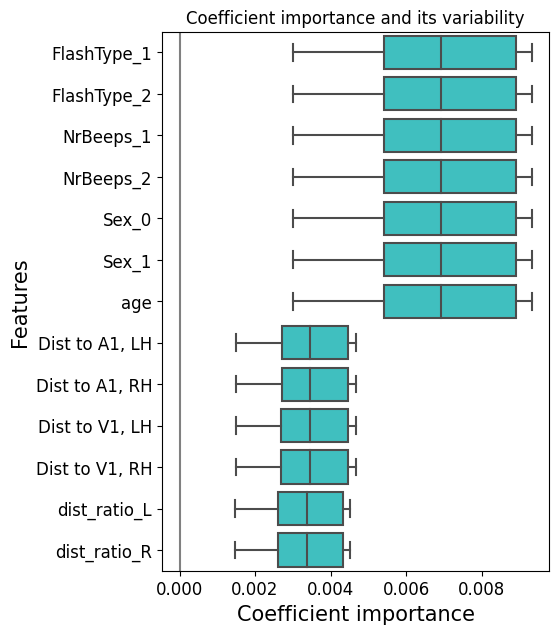

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=coefs.iloc[:, :100], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
ax.set_ylabel("Features", fontsize = 15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")